In [1]:
import os
import sys
sys.path.append('../')
sys.path.append('../datasets')
sys.path.append('../models')
import torch
import torchvision
import torch.backends.cudnn as cudnn
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from importlib import reload
from datasets.three_dim_shapes import ThreeDimShapesDataset
from datasets.small_norb import SmallNORBDataset
from datasets.seq_mnist import SequentialMNIST
import models.seqae as seqae
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import Ridge
from datasets import so3_data as so3d
from einops import rearrange
from sklearn.metrics import r2_score
import pdb
import copy

import csv
import ast
from source import yaml_utils as yu


from tqdm import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
    cudnn.deterministic = True
    cudnn.benchmark = True
else:
    device = torch.device('cpu')
    gpu_index = -1

    
    
from utils import yaml_utils as yu
import yaml
rootpath = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/'
result_dir = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/result'






# Is this method really working? 
from utils import optimize_bd_cob as obc
from importlib import reload
reload(obc)




datroot = '/mnt/nfs-mnj-hot-01/tmp/masomatics/block_diag/datasets/so3'

os.listdir(datroot)

['so3dat_sphere_MLP.pt',
 'so3dat_sphere_Linear_model.pt',
 'so3dat_sphere_iResNet_shared_trans.pt',
 'so3dat_sphere_iResNet_model.pt',
 'so3dat_sphere_MLP_shared_trans.pt',
 'so3dat_sphere_Identity_model.pt',
 'so3dat_sphere_Linear_model_invhat.pt',
 'so3dat_sphere_Identity.pt',
 'so3dat_sphere_iResNet.pt',
 'so3dat_sphere_MLP_model.pt',
 'so3dat_sphere_Linear.pt',
 'so3dat_sphere_MLP_model_invhat.pt',
 'so3dat_sphere_Linear_shared_trans.pt']

In [2]:
datpath = os.path.join(datroot, 'so3dat_sphere_Linear.pt')
mydat = torch.load(datpath)

torch.Size([10000, 6, 6])


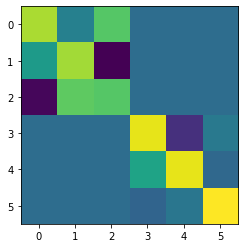

In [3]:
mdat = [mydat['trans'][k][1] for k in range(len(mydat['trans']))]
mdat = torch.stack(mdat)
print(mdat.shape)
plt.imshow(mdat[0])

torch.Size([10000, 6, 6])


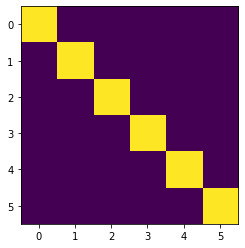

In [14]:
datsize = 10000
dim = 6
diag_mats = np.zeros([datsize, dim, dim])
mode = 'so2'
#orthog = True


for k in range(datsize):
    if mode == 'so3':
        w1 = torch.tensor(np.random.uniform(0, 1, size=3))
        theta1= torch.tensor(
                    np.random.uniform(0, np.pi/2. * 0.8, size=1))

        w2 = torch.tensor(np.random.uniform(0, 1, size=3))
        theta2 = torch.tensor(
                    np.random.uniform(0, np.pi/2. * 0.8, size=1))
        diag_mats[k][:3, :3] = so3d.rodrigues_rotation(w1, theta1)
        diag_mats[k][3:, 3:] = so3d.rodrigues_rotation(w2, theta2)
    elif mode == 'three':
        diag_mats[k][:3, :3] = np.random.normal(size=(3,3))
        diag_mats[k][3:, 3:] = np.random.normal(size=(dim-3,dim-3))   
    elif mode == 'so2':
        theta1= torch.tensor(
                    np.random.uniform(0, np.pi/2. * 0.8, size=1))
        theta2= torch.tensor(
                    np.random.uniform(0, np.pi/2. * 0.8, size=1))  
        theta3= torch.tensor(
                    np.random.uniform(0, np.pi/2. * 0.8, size=1)) 
        diag_mats[k][:2, :2] = so3d.two_d_rotation(theta1)
        diag_mats[k][2:4, 2:4] = so3d.two_d_rotation(theta2)
        diag_mats[k][4:, 4:] = so3d.two_d_rotation(theta3)        
        
    elif mode == 'two':
        diag_mats[k][:2, :2] = np.random.normal(size=(2,2))
        diag_mats[k][2:4, 2:4] = np.random.normal(size=(2,2))
        diag_mats[k][4:, 4:] = np.random.normal(size=(2,2))


diag_mats = torch.tensor(diag_mats).float()

print(diag_mats.shape)
checkid = 0
plt.imshow(diag_mats[checkid])
plt.imshow(diag_mats[checkid] @ diag_mats[checkid].permute([1,0]))

In [15]:

#DEBUG
#diag_mats = mdat 

In [16]:
P0 = torch.tensor(np.random.normal(size=(dim,dim))).float()
Change0 = obc.ChangeOfBasis(d=dim, Pmat=P0)

synth_mats = Change0(diag_mats).detach()

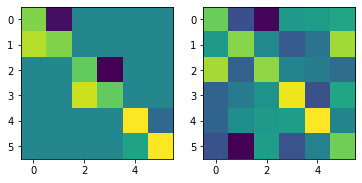

In [17]:
checkid = 4
check = P0 @ synth_mats[checkid] @ torch.linalg.inv(P0)
plt.subplot(121)
plt.imshow(check.detach())
plt.subplot(122)
plt.imshow(synth_mats[checkid].detach())

In [24]:
reload(obc)
mylr = 0.01 
S = synth_mats
#S = diag_mats
#STS = torch.matmul(S.transpose(-2, -1), S)
Change1 = obc.optimize_bd_cob(S, epochs_monitor=5, lr=mylr)
diaghat = Change1(S).detach()



ep:4 loss:2.415237759399414
ep:9 loss:2.407547289276123
ep:14 loss:2.400810676574707
ep:19 loss:2.3997192848205566
ep:24 loss:2.3987188621520996
ep:29 loss:2.398674774932861
ep:34 loss:2.398061546707153
ep:39 loss:2.397379072189331
ep:44 loss:2.39806669921875
ep:49 loss:2.396882283401489


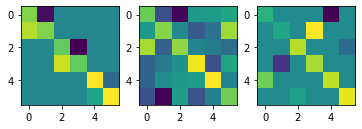

In [25]:
checkid = 4



plt.subplot(131)
plt.imshow(diag_mats[checkid].detach())
plt.subplot(132)
plt.imshow(S[checkid].detach())
plt.subplot(133)
plt.imshow(diaghat[checkid].detach())

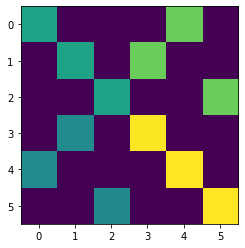

In [26]:
plt.imshow(torch.mean(torch.abs(diaghat) , axis =0).detach())

In [44]:
len(diag_mats)

10000